In [1]:
import mne, os, glob
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib qt 

In [2]:
""" 
Load data
"""
# Big list
ep_list = []
# Specify the epoch length we will be looking at
epoch_tmin = -0.1
epoch_tmax = 0.95

cleaned_data_dir = 'C:/Users/mvmigem/Documents/data/project_1/preprocessed/mastoid_last_stim/'
dir_list = glob.glob(cleaned_data_dir+'*-epo.fif')
excuded_pp = [3,14,20]

# Iterate throug data folders 
for i,sub_path in enumerate(dir_list):
    sub = int(sub_path.split('last_stim_')[1].split('-epo.fif')[0])
    if sub in excuded_pp:
        continue
    clean_epoch_path = sub_path
    epochs = mne.read_epochs(clean_epoch_path)
    epochs.info['bads']= []
    ep_list.append(epochs)
    print(epochs.info['nchan'])

# Concat list into big epoch object with all data
eps = mne.concatenate_epochs(ep_list).crop(tmin=epoch_tmin,tmax=epoch_tmax)

# Load peak properties of localiser data
peak_properties = pd.read_csv(r'C:\Users\mvmigem\Documents\data\project_1\compiled_dataframes\c1_peak_properties.csv')

Reading C:\Users\mvmigem\Documents\data\project_1\preprocessed\mastoid_last_stim\last_stim_01-epo.fif ...
    Found the data of interest:
        t =     -97.66 ...    1000.00 ms
        0 CTF compensation matrices available
Adding metadata with 36 columns
829 matching events found
No baseline correction applied
0 projection items activated
69
Reading C:\Users\mvmigem\Documents\data\project_1\preprocessed\mastoid_last_stim\last_stim_02-epo.fif ...
    Found the data of interest:
        t =     -97.66 ...    1000.00 ms
        0 CTF compensation matrices available
Adding metadata with 36 columns
839 matching events found
No baseline correction applied
0 projection items activated
69
Reading C:\Users\mvmigem\Documents\data\project_1\preprocessed\mastoid_last_stim\last_stim_04-epo.fif ...
    Found the data of interest:
        t =     -97.66 ...    1000.00 ms
        0 CTF compensation matrices available
Adding metadata with 36 columns
840 matching events found
No baseline correction ap

C:\Users\mvmigem\AppData\Local\Temp\ipykernel_18808\2364374423.py:26: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  eps = mne.concatenate_epochs(ep_list).crop(tmin=epoch_tmin,tmax=epoch_tmax)


Adding metadata with 38 columns
18928 matching events found
Applying baseline correction (mode: mean)


C:\Users\mvmigem\AppData\Local\Temp\ipykernel_18808\2364374423.py:26: RuntimeWarning: tmin is not in time interval. tmin is set to <class 'mne.epochs.EpochsArray'>.tmin (-0.0976562 s)
  eps = mne.concatenate_epochs(ep_list).crop(tmin=epoch_tmin,tmax=epoch_tmax)


In [3]:
sub_list = eps.metadata['participant'].unique() 
epochs_nocatch = eps['catch_trial == 0']
epochs_attended = epochs_nocatch['attention == "attended"']
epochs_unattended = epochs_nocatch['attention == "unattended"']

In [4]:
evoked_att_list = []
evoked_unatt_list = []
evoked_att_select_list = []
evoked_unatt_select_list = []
common_ch_name = 'combined_channel'
for i,sub in enumerate(sub_list):
    the_row = peak_properties[peak_properties['subject'] == sub]
    channel = the_row['all_pos_peak_channel'].iloc[0]

    ep_att = epochs_attended[f'participant == {sub}'].average()
    ep_unatt = epochs_unattended[f'participant == {sub}'].average()
    evoked_att_list.append(ep_att)
    evoked_unatt_list.append(ep_unatt)
    ep_att_sel = ep_att.copy().pick(channel)
    ep_unatt_sel = ep_unatt.copy().pick(channel)
    evoked_att_select_list.append(ep_att_sel.rename_channels({ep_att_sel.ch_names[0]: common_ch_name}))
    evoked_unatt_select_list.append(ep_unatt_sel.rename_channels({ep_unatt_sel.ch_names[0]: common_ch_name}))

evoked_att = mne.grand_average(evoked_att_list)
evoked_unatt = mne.grand_average(evoked_unatt_list)
evoked_att_select = mne.grand_average(evoked_att_select_list)
evoked_unatt_select = mne.grand_average(evoked_unatt_select_list)


Identifying common channels ...
Identifying common channels ...
Identifying common channels ...
Identifying common channels ...


In [5]:
scale = [None,None]
ev_names = ('attended','unattended')
evokeds_list1 = [evoked_att,evoked_unatt]
evokeds_list2 = [evoked_att_select,evoked_unatt_select]

norm1 = dict(zip(ev_names, evokeds_list1))
norm2 = dict(zip(ev_names, evokeds_list2))

mne.viz.plot_compare_evokeds(norm1, picks='POz', vlines=[0.05,0.1],ylim=dict(eeg=scale))
mne.viz.plot_compare_evokeds(norm2, vlines=[0.05,0.1],ylim=dict(eeg=scale))

[<Figure size 800x600 with 2 Axes>]

In [9]:
# Prepare data for plot_compare_evokeds with confidence intervals
evokeds_dict = {
    'peripheral attention': evoked_att_select_list,  # list of individual subject evokeds
    'central attention': evoked_unatt_select_list
}

# Plot with confidence intervals
mne.viz.plot_compare_evokeds(
    evokeds_dict,
    vlines=[0.05, 0.1,0.5],
    ylim=dict(eeg=scale),
    title='Evoked Responses with 95% CI'
)

[<Figure size 800x600 with 2 Axes>]

In [16]:
# Define time window of interest
tmin, tmax = 0.5, 0.95  # 450-950 ms in seconds

# Initialize lists to store data
data = []
subject_ids = []
conditions = []

# Process peripheral attention condition
for i, evoked in enumerate(evoked_att_select_list):
    # Get data and times
    times = evoked.times
    data_array = evoked.get_data(picks='eeg')  # Get EEG data
    
    # Find time indices in our window of interest
    time_mask = (times >= tmin) & (times <= tmax)
    
    # Calculate mean amplitude across channels and time window
    mean_amp = np.mean(data_array[:, time_mask])
    
    # Store results
    data.append(mean_amp)
    subject_ids.append(f'S{i+1:02d}')  # S01, S02, etc.
    conditions.append('peripheral')

# Process central attention condition  
for i, evoked in enumerate(evoked_unatt_select_list):
    # Get data and times
    times = evoked.times
    data_array = evoked.get_data(picks='eeg')
    
    # Find time indices in our window of interest
    time_mask = (times >= tmin) & (times <= tmax)
    
    # Calculate mean amplitude across channels and time window
    mean_amp = np.mean(data_array[:, time_mask])
    
    # Store results
    data.append(mean_amp)
    subject_ids.append(f'S{i+1:02d}')
    conditions.append('central')

# Create DataFrame
df_amplitudes = pd.DataFrame({
    'subject': subject_ids,
    'attention': conditions,
    'y': data
})

print(df_amplitudes.head())

  subject   attention             y
0     S01  peripheral -1.571395e-06
1     S02  peripheral -1.309893e-06
2     S03  peripheral  7.579361e-07
3     S04  peripheral  3.400153e-07
4     S05  peripheral -3.434066e-07


In [17]:
df_amplitudes['y'] = df_amplitudes['y'] *1e6
output_path = f"C:/Users/mvmigem/Documents/data/project_1/compiled_dataframes/seq4_late.csv"
df_amplitudes.to_csv(output_path)

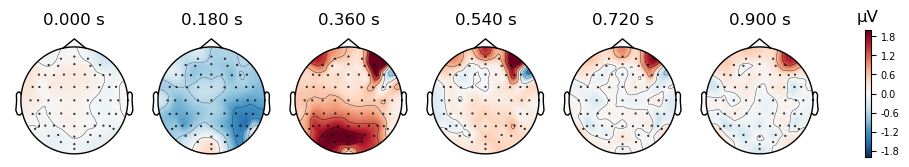

In [10]:
tim = np.linspace(0.0, 0.9,6)
vlim = (-2.0, 2.0)
# vlim = (None, None)

# diff_att_up.plot_topomap(ch_type="eeg", times=tim, colorbar=True,vlim=vlim)
# diff_unatt_up.plot_topomap(ch_type="eeg", times= tim, colorbar=True,vlim=vlim)
# diff_att_down.plot_topomap(ch_type="eeg", times=tim, colorbar=True,vlim=vlim)
# diff_unatt_down.plot_topomap(ch_type="eeg", times= tim, colorbar=True,vlim=vlim)
evoked_att.plot_topomap(ch_type="eeg", times=tim, colorbar=True,vlim=vlim)
evoked_unatt.plot_topomap(ch_type="eeg", times= tim, colorbar=True,vlim=vlim)